In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imageio

sector_size = 3 # size of the sector used to embed the secret message
idx = 1 # center of the sector


In [2]:
# Convert from RGB or RGBA to HSV
def convertHSV(img):
    return matplotlib.colors.rgb_to_hsv(img[:,:,:3].astype(np.float64))

# Convert from HSV to RGB
def convertRGB(img):
    return matplotlib.colors.hsv_to_rgb(img.astype(np.float64))

# Normalize image
def normalize(img):
    imgMin = np.min(img)
    imgMax = np.max(img)
    return (img-imgMin)/(imgMax-imgMin)

# Get V channel of HSV image with values [0, 1]
def floatV(img):
    return img[:,:,2].astype(np.float64)/255

# Execute modulo operation in a image
def modulo(img, value):
    return (img.astype(np.int64)+value) % value

# Apply FFT and shift
def applyFFT(img):
    imgFFT = np.fft.fft2(img)
    return np.fft.fftshift(imgFFT)

# Apply shift and IFFT
def applyIFFT(img):
    imgShift = np.fft.ifftshift(img)
    imgIFFT = np.fft.ifft2(imgShift)
    return imgIFFT

# Main embedding function:
# We apply FFT on both images, then we divide the base image into 
# sectors of sector_size x sector_size.
# On the center of each sector (given by idx), we embed each secret message's frequency value
def encode(img1, img2):
    imgBase = applyFFT(np.copy(img1))
    height, width = imgBase.shape
    
    imgSecret = applyFFT(img2)
    imgSecretFlat = imgSecret.flatten()
    ind = 0
    
    if((height*width)/sector_size**2 < len(imgSecretFlat)):
        print('Encoding not possible')
    
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(imgSecretFlat):
                imgBase[x+idx, y+idx] = imgSecretFlat[ind]
                ind += 1
            else:
                break
    return applyIFFT(imgBase)

# Main decoding function:
# Similar to the embedding function, we recover the secret message
# from the base image that was previously encoded
def decode(img1,key):
    imgBase = applyFFT(img1)
    height, width = imgBase.shape
    
    secret_h, secret_w = key
    secret = np.zeros((secret_h*secret_w), dtype=np.complex128)
    ind = 0
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(secret):
                secret[ind] = imgBase[x+idx, y+idx]
                ind += 1
            else:
                break
    secret = secret.reshape((secret_h,secret_w))
    return applyIFFT(secret)

    

In [3]:
imgBaseName = './images/input.jpg'
imgSecretName = './images/qr.png'

# reading the base image
imgBase = plt.imread(imgBaseName)
imgBaseHSV = convertHSV(imgBase)
imgBaseV = floatV(imgBaseHSV)

# reading the secret message
imgSecret = plt.imread(imgSecretName)
imgSecretHSV = convertHSV(imgSecret)
imgSecretV = floatV(imgSecretHSV)

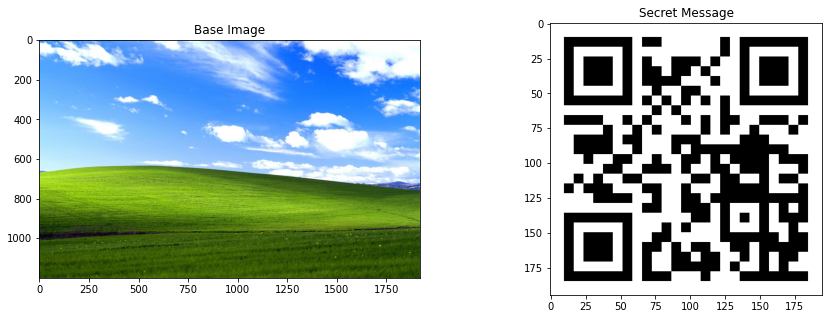

In [4]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax1.title.set_text('Base Image')
plt.imshow(imgBase)


ax2 = plt.subplot(122)
ax2.title.set_text('Secret Message')
plt.imshow(imgSecret)


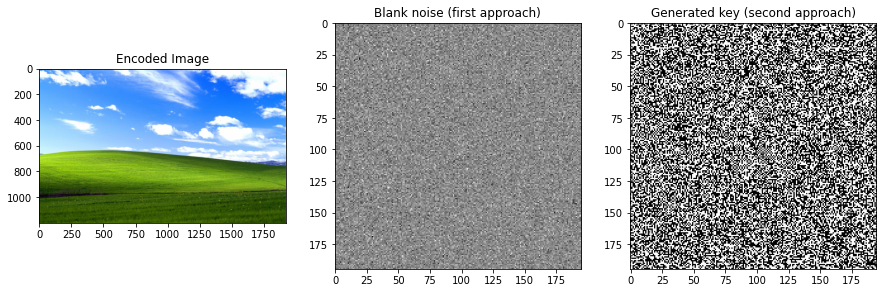

In [5]:
# embedding the secret message
encodedImageV = encode(imgBaseV, imgSecretV).real
encodedImage = imgBaseHSV
encodedImage[:,:,2] = encodedImageV.astype(np.float64)*255

# image used to remove some noise on the encoded image
blankImage = np.zeros(imgSecretV.shape)+1
noise = decode(encode(imgBaseV, blankImage).real, imgSecretV.shape).real

# converting the image back to rgb and saving the encoded image (first approach)
finalImage = np.copy(imgBase)
finalImage[:,:,:3] = convertRGB(encodedImage)
imageio.imsave('./images/input+qr.png', finalImage)

# create a decode key from the noise generated (second approach)
finalImageHSV = convertHSV(finalImage)
finalImageV = floatV(finalImageHSV)
noisySecret = decode(finalImageV, imgSecretV.shape).real
key = modulo((noisySecret*255).astype(np.int32)-(imgSecretV*255).astype(np.int32), 256).astype(np.uint8)
imageio.imsave('./images/key.png', key)

plt.figure(figsize=(15,5))
ax = plt.subplot(131)
ax.title.set_text('Encoded Image')
plt.imshow(finalImage)

ax = plt.subplot(132)
ax.title.set_text('Blank noise (first approach)')
plt.imshow(noise, cmap='gray')

ax = plt.subplot(133)
ax.title.set_text('Generated key (second approach)')
plt.imshow(key, cmap='gray')

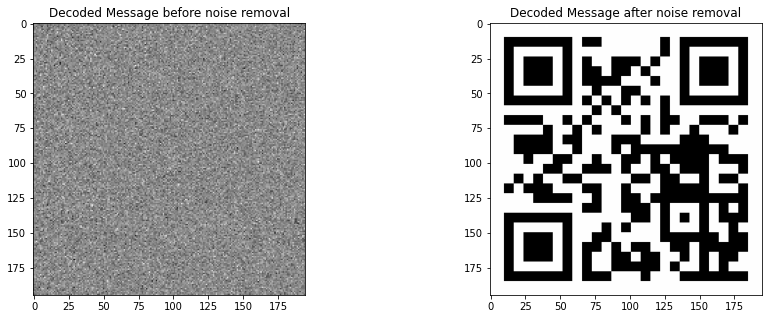

In [6]:
# retrieving the secret message thats embedded on the encoded image using the first approach
secret = decode(encodedImageV, imgSecretV.shape).real
finalSecret = (normalize(secret.real-noise.real)*255).astype(np.uint8)
imageio.imsave('./images/decoded_first1.png', finalSecret)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('Decoded Message before noise removal')
plt.imshow(secret, cmap="gray")

ax = plt.subplot(122)
ax.title.set_text('Decoded Message after noise removal')
plt.imshow(finalSecret, cmap="gray")

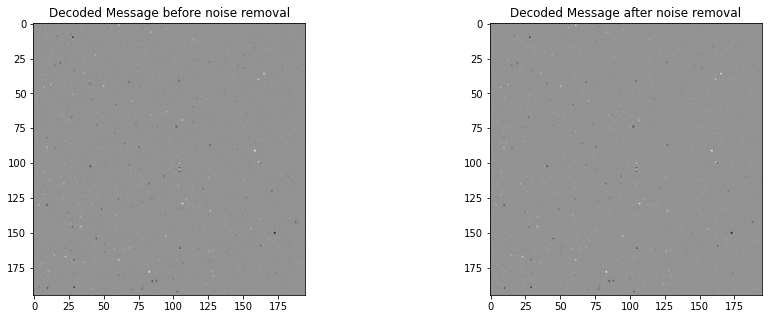

In [7]:
# retrieving the secret message thats embedded on the encoded image using the first approach with saved image
receivedImage = imageio.imread('./images/input+qr.png')
receivedImageHSV = convertHSV(receivedImage)
receivedImageV = floatV(receivedImageHSV)

secret = decode(receivedImageV, imgSecretV.shape).real
finalSecret = (normalize(secret.real-noise.real)*255).astype(np.uint8)
imageio.imsave('./images/decoded_first2.png', finalSecret)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('Decoded Message before noise removal')
plt.imshow(secret, cmap="gray")

ax = plt.subplot(122)
ax.title.set_text('Decoded Message after noise removal')
plt.imshow(finalSecret, cmap="gray")

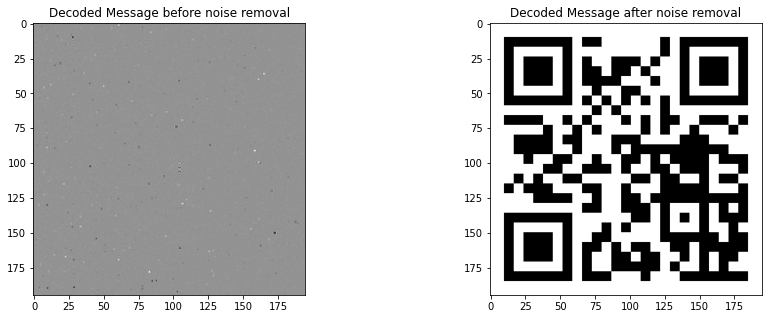

In [8]:
# retrieving the secret message thats embedded on the encoded image using the second approach
receivedImage = imageio.imread('./images/input+qr.png')
receivedImageHSV = convertHSV(receivedImage)
receivedImageV = floatV(receivedImageHSV)

receivedKey = imageio.imread('./images/key.png')

secret = decode(receivedImageV, receivedKey.shape).real
finalSecret = (modulo((secret.real*255).astype(np.int32)-receivedKey, 256)).astype(np.uint8)
imageio.imsave('./images/decoded_second.png', finalSecret)

plt.figure(figsize=(15,5))
ax = plt.subplot(121)
ax.title.set_text('Decoded Message before noise removal')
plt.imshow(secret, cmap="gray")

ax = plt.subplot(122)
ax.title.set_text('Decoded Message after noise removal')
plt.imshow(finalSecret, cmap="gray")